# Homework 3

## Task 1
Bauer Müller hat vergessen, welche und wie viele Arten Kartoffeln er im April gelegt hat. Bei
der Ernte katalogisiert er Daten, die ihm relevant erscheinen um herauszufinden, welche und
wie viele Kartoffelarten er ausgebracht hat. Im vorliegenden Datensatz kartoffeln.arff sind
bereits normalisierte Daten für 600 Beispiel-Kartoffeln gespeichert. Dass es sich um 3
Klassen handelt, die über das „kartoffelart“ Attribut gekennzeichnet sind, wissen wir leider
nicht. Entsprechend soll der bekannte Clusteralgorithmus k-means auf dem Datensatz
angewendet werden, um herauszufinden, wie viele Kartoffelarten vorliegen und wie diese
jeweils zu erkennen sind.


### a)

Führen Sie eine kurze Vorverarbeitung durch. Beachten Sie dabei, dass das
Klassenattribut nicht (no class) bekannt ist!

In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from kneed import KneeLocator
from matplotlib.ticker import MaxNLocator
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler


potatos = pd.read_csv('kartoffeln.csv')
# initial cleanup
# remove leading and trailing blanks
potatos.columns = potatos.columns.str.strip()
# the data are pandas dataframe -> potatos.drop()
potatos = potatos.drop(['kartoffel'], axis=1)  # drop index column
# do data type check and conversion
dtypes_after_read = potatos.dtypes
# change the class to category -> must not be not scaled!
potatos['kartoffelart'] = potatos['kartoffelart'].astype('category')
dtypes_after_cleanup = potatos.dtypes

X_raw = potatos.iloc[:, :-1]
labels = potatos.columns
y = potatos['kartoffelart']

scaler = MinMaxScaler()
X = scaler.fit_transform(X_raw)
#print(tabulate(X))
print(pd.DataFrame(X[:10,:], columns=labels[:-1]))

   gewicht  legetiefe  laenge  hoehe_gruenwuchs  qualitaet
0   0.4876     0.8055  0.6561            0.5753     0.0891
1   0.4876     0.8236  0.4014            0.8631     0.2293
2   0.6531     0.6696  0.6142            0.8001     0.2250
3   0.7366     0.7990  0.4870            0.8321     0.0334
4   0.4599     0.5946  0.4845            0.2257     0.3467
5   0.5167     0.7416  0.5101            0.1485     0.2603
6   0.6111     0.6721  0.3448            0.5186     0.2317
7   0.3251     0.9534  0.3858            0.8240     0.4536
8   0.5483     0.8151  0.2731            0.1703     0.2095
9   0.3751     0.8344  0.3412            0.3139     0.0519


### b)

Verwenden Sie für k die Werte 2, 3, 5 und 12. Welche Lösung stellt anhand des SSE-
Werts aus Weka die beste dar? Inwieweit ist die Güte des Ergebnisses zu bewerten?
Gibt es weitere Möglichkeiten zur Evaluation der Clusterlösungen (nur nennen)?


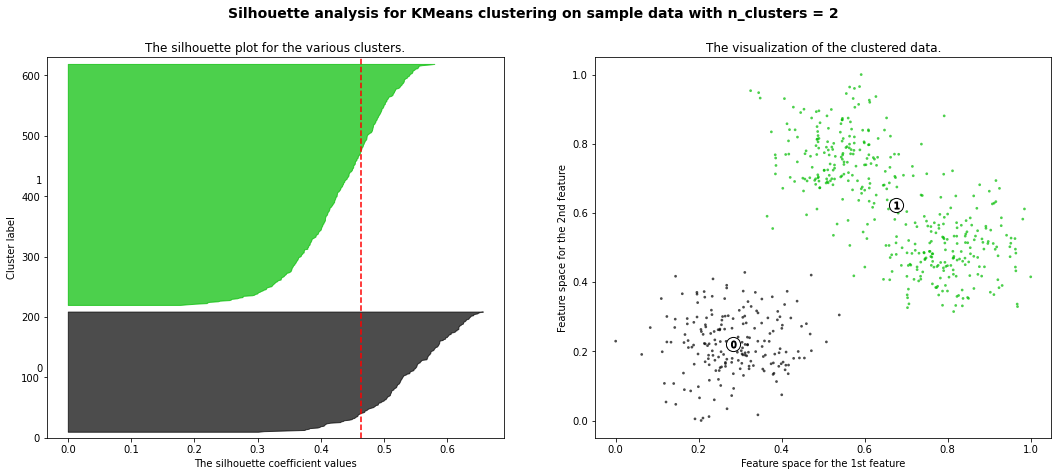

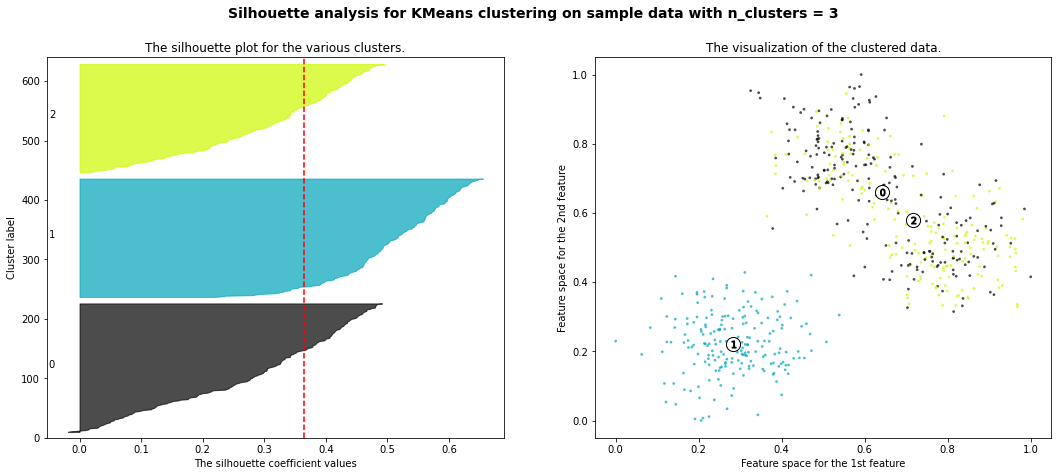

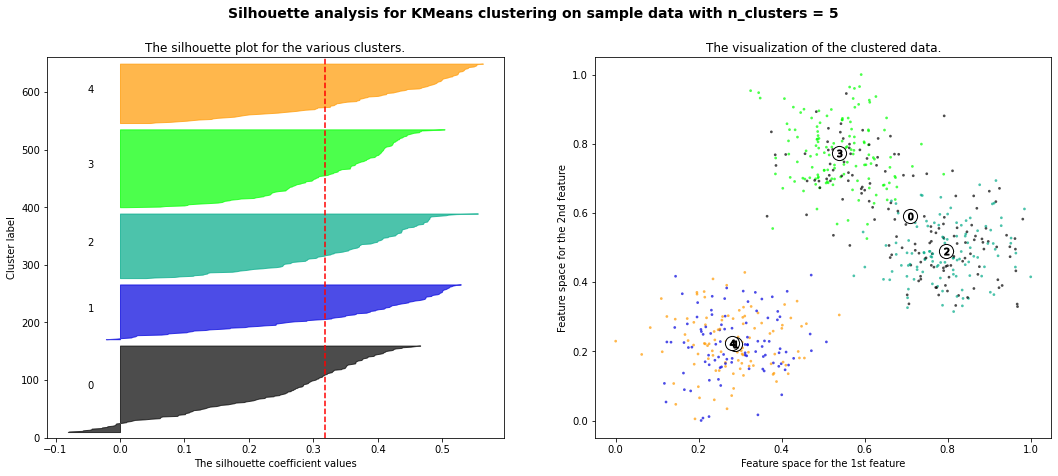

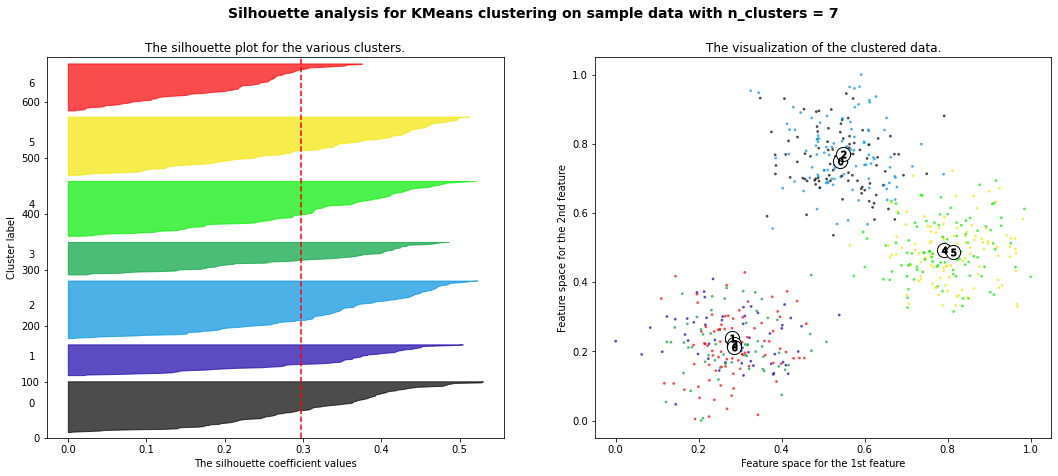

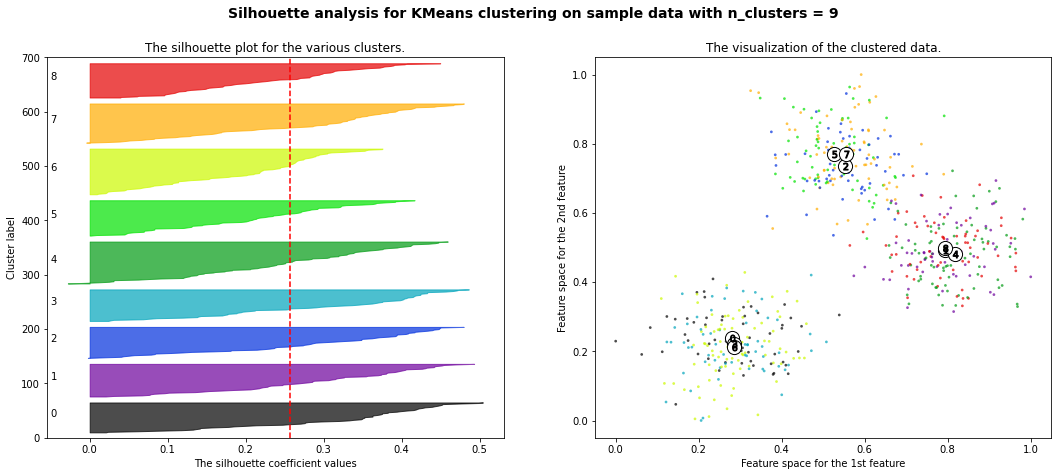

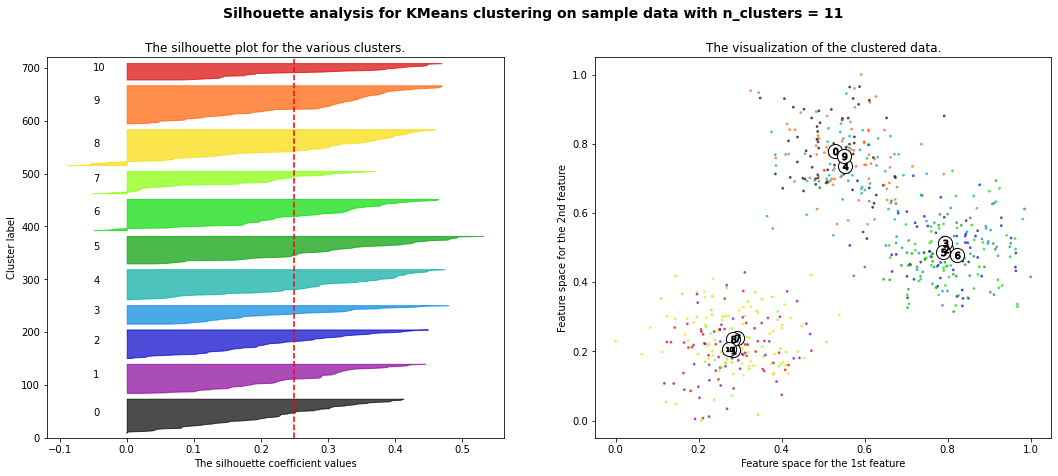

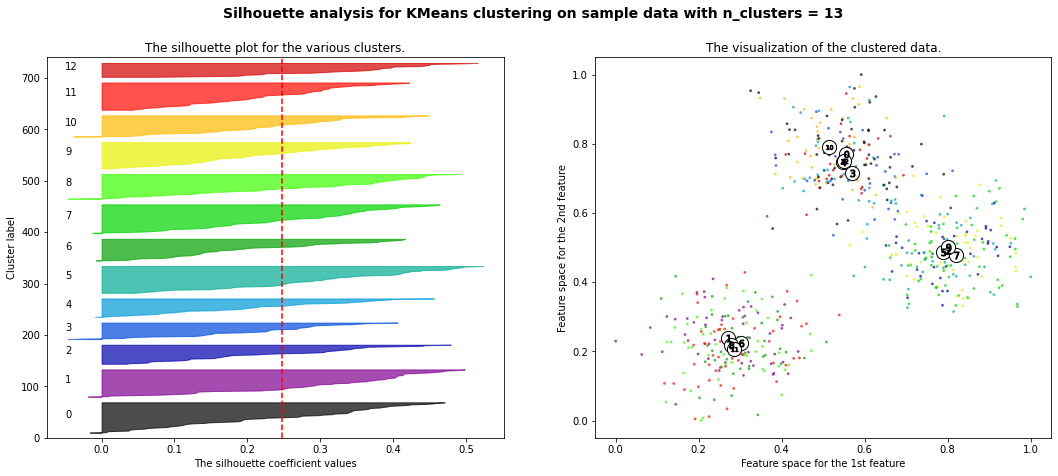

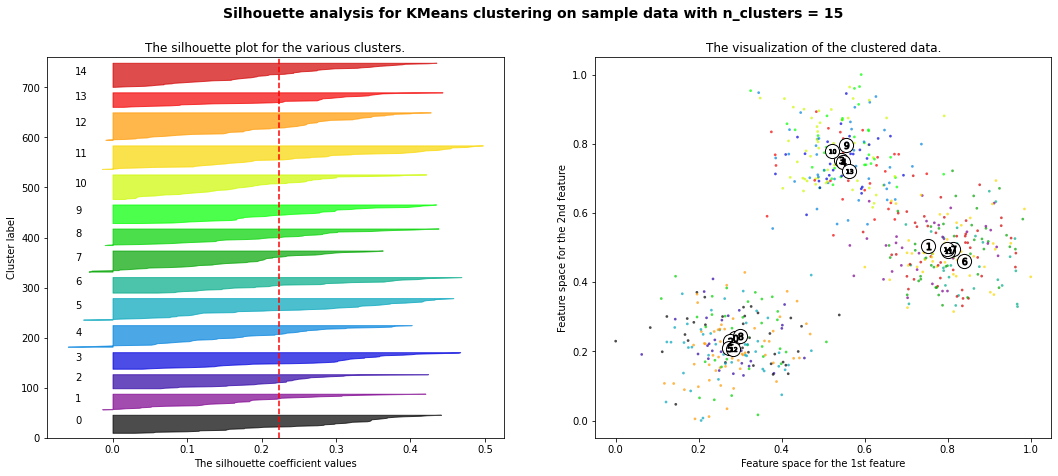

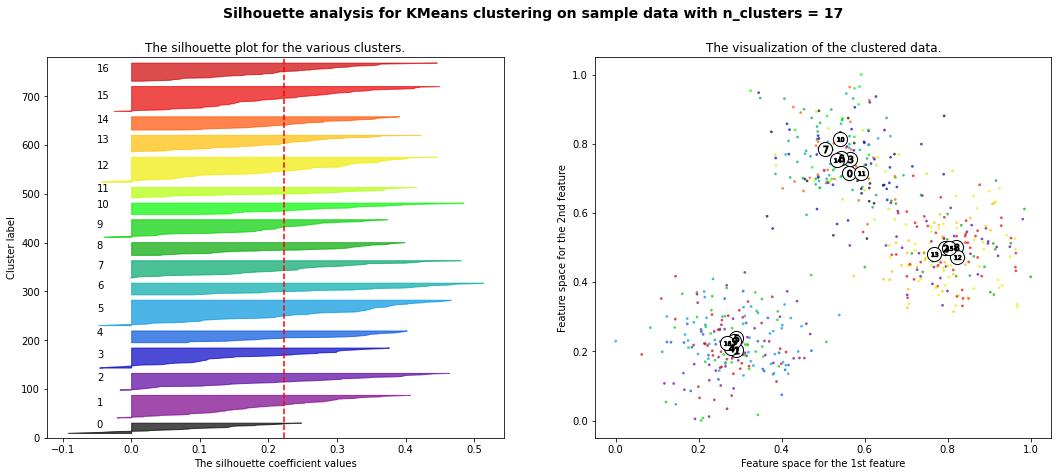

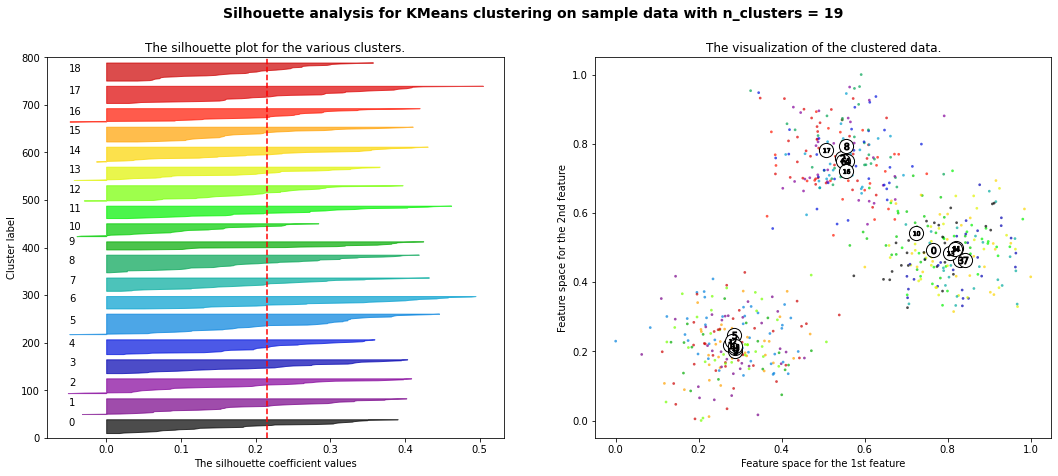

Best Silhouette Coefficient with number of clusters 2
Best SSE Coefficient with number of clusters 2


In [2]:
#n_cluster = [2, 3, 5, 12]
n_cluster = [2] + list(np.arange(3,12,2))

silhouette_data = pd.DataFrame(columns=['number_of_clusters', 'silhouette_score_avg', 'sample_silhouette_values','RAND_index','model_predict'])

for k in n_cluster:
	model = KMeans(n_clusters=k,
				   random_state=0,
				   n_init=10,
				   max_iter=300)
	model_predict = model.fit_predict(X)
	silhouette_score_avg = silhouette_score(X, model_predict)
	sample_silhouette_values = silhouette_samples(X, model_predict)
	sse = model.inertia_

	# validate against known cluster
	# from sklearn.metrics import adjusted_rand_score
	RAND_index=adjusted_rand_score(y, model_predict)
	#print('RAND: {:.2f}'.format(RAND_index))

	# Create a subplot with 1 row and 2 columns
	fig, (ax1, ax2) = plt.subplots(1, 2)
	fig.set_size_inches(18, 7)

	# The 1st subplot is the silhouette plot
	# The silhouette coefficient can range from -1, 1
	# ax1.set_xlim([-1, 1])
	# The (k+1)*10 is for inserting blank space between silhouette
	# plots of individual clusters, to demarcate them clearly.
	ax1.set_ylim([0, len(X) + (k + 1) * 10])

	y_lower = 10
	for i in range(k):
		# Aggregate the silhouette scores for samples belonging to
		# cluster i, and sort them
		ith_cluster_silhouette_values = sample_silhouette_values[model_predict == i]
		ith_cluster_silhouette_values.sort()

		size_cluster_i = ith_cluster_silhouette_values.shape[0]
		# equiviliant
		size_cluster_i = len(ith_cluster_silhouette_values)

		y_upper = y_lower + size_cluster_i

		color = cm.nipy_spectral(float(i) / k)
		ax1.fill_betweenx(np.arange(y_lower, y_upper),
						  0, ith_cluster_silhouette_values,
						  facecolor=color, edgecolor=color, alpha=0.7)

		# Label the silhouette plots with their cluster numbers at the middle
		ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

		# Compute the new y_lower for next plot
		y_lower = y_upper + 10  # 10 for the 0 samples

	ax1.set_title("The silhouette plot for the various clusters.")
	ax1.set_xlabel("The silhouette coefficient values")
	ax1.set_ylabel("Cluster label")

	# The vertical line for average silhouette score of all the values
	ax1.axvline(x=silhouette_score_avg, color="red", linestyle="--")

	# 2nd Plot showing the actual clusters formed
	colors = cm.nipy_spectral(model_predict.astype(float) / k)
	ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
				c=colors, edgecolor='k')

	# Labeling the clusters
	centers = model.cluster_centers_
	# Draw white circles at cluster centers
	ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
				c="white", alpha=1, s=200, edgecolor='k')

	for i, c in enumerate(centers):
		ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
					s=50, edgecolor='k')

	ax2.set_title("The visualization of the clustered data.")
	ax2.set_xlabel("Feature space for the 1st feature")
	ax2.set_ylabel("Feature space for the 2nd feature")

	plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
				  "with n_clusters = {:d}".format(k)),
				 fontsize=14, fontweight='bold')

	plt.show()

	silhouette_data_dict = dict(number_of_clusters=k,
								silhouette_score_avg=silhouette_score(X, model_predict),
								sample_silhouette_values=silhouette_samples(X, model_predict),
								sse=sse,
                                model_predict=model_predict,
                                RAND_index=RAND_index)
	silhouette_data = silhouette_data.append(silhouette_data_dict, ignore_index=True)

max_avg = silhouette_data['silhouette_score_avg'].max()
best_k_silhouette = silhouette_data[silhouette_data['silhouette_score_avg'] == max_avg]['number_of_clusters'][0]
print('Best Silhouette Coefficient with number of clusters {:d}'.format(best_k_silhouette))
best_k_sse = KneeLocator(n_cluster, silhouette_data['sse']).elbow
print('Best SSE Coefficient with number of clusters {:d}'.format(best_k_silhouette))

### Antwort:
Die beste Lösung ist laut K=2
Methoden zur Beurteilung sind
+ Silhouette Plot
+ Adjusted RAND Score (ARI)

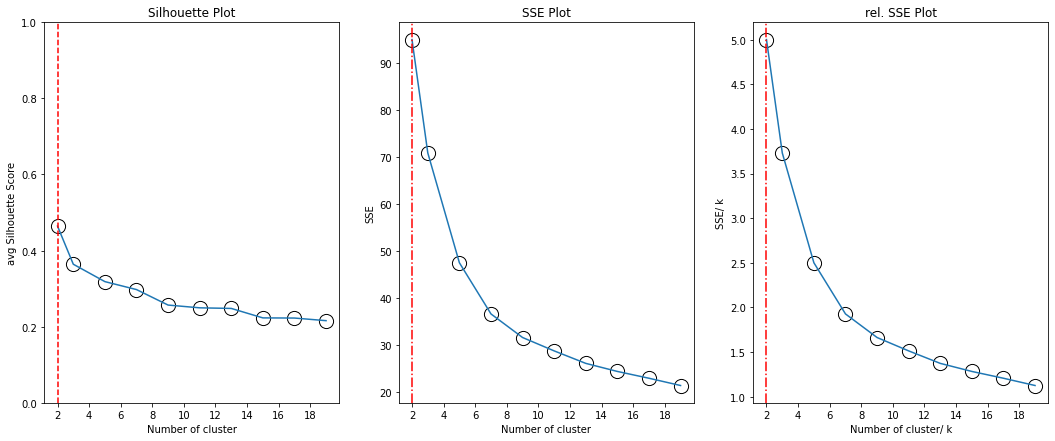

In [8]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(18, 7)

x = silhouette_data['number_of_clusters']
y = (silhouette_data['sse'])/k
ax[2].set_xlabel('Number of cluster')
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2].set_ylabel('SSE/ k')
ax[2].set_title('rel. SSE Plot')
ax[2].plot(x, y)
ax[2].scatter(x, y, marker='o', c="white", alpha=1, s=200, edgecolor='k')
ax[2].axvline(x=best_k_sse, color="red", linestyle="-.")


x = silhouette_data['number_of_clusters']
y = silhouette_data['sse']
ax[1].set_xlabel('Number of cluster')
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_ylabel('SSE')
ax[1].set_title('SSE Plot')
ax[1].plot(x, y)
ax[1].scatter(x, y, marker='o', c="white", alpha=1, s=200, edgecolor='k')
ax[1].axvline(x=best_k_sse, color="red", linestyle="-.")

x = silhouette_data['number_of_clusters']
y = silhouette_data['silhouette_score_avg']
ax[0].set_xlabel('Number of cluster')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_ylabel('avg Silhouette Score')
ax[0].set_ylim(0, 1)
ax[0].set_title('Silhouette Plot')
ax[0].plot(x, y, )
ax[0].scatter(x, y, marker='o', c="white", alpha=1, s=200, edgecolor='k')
ax[0].axvline(x=best_k_silhouette, color="red", linestyle="--")

plt.show()

### c)
Evaluation mit dem KlassenattributVerwenden Sie das Klassenattribut zur Evaluation der Clusterlösung (siehe Abbildung).Welche Konfiguration (der oben genannten) erzielt jetzt das beste Ergebnis?Warum?


In [ ]:
best_RAND_index = silhouette_data['RAND_index'].max()
best_k_rand = silhouette_data[silhouette_data['RAND_index'] == best_RAND_index]
best_k_rand= best_k_rand['number_of_clusters'][0]
print('Best RAND index {:3f} with {:.0f} cluster'.format(best_RAND_index, best_k_rand))


### d)
Wie lassen sich auf Basis dieser Erkenntnisse die Klassen bzw. die den Klassen
zugeordneten Cluster beschreiben? (z.B.: Cluster 1: extrem tiefliegende, sehr kleine
Kartoffeln, Wuchshöhe mit einem Mittel von X weit unter den Werten von Cluster 2
und Cluster 3)

In [ ]:
import plotly.express as px

model_predict = silhouette_data[silhouette_data['number_of_clusters'] == best_k_silhouette]

model_predict = pd.DataFrame(model_predict)['model_predict'].values
model_predict = pd.DataFrame(model_predict[0], columns=['cluster'])

Xy= pd.concat([X_raw,model_predict], axis = 1)
Xy['cluster'].astype('category')

fig = px.parallel_coordinates(Xy, color='cluster',
                              color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()


## Task 2
Gegeben ist der folgende (aus der Übung bereits bekannte) Datensatz:
A(2,10); B(2,5); C(8,4); D(5,8); E(7,5); F(6,4); G(1,2); H(4,9)

### a)
Stellen sie die benötigte Distanzmatrix mit Hilfe der L3-Norm auf. Werden alle Felder
für die hierarchische Clusterung benötigt?
### b)
Verwenden Sie das agglomerative hierarchische Clusterverfahren mit einer selbst gewählten Methode zur Bewertung von Abständen (single, min, max, centroid,...)und stellenSie das Dendrogrammdar.

In [ ]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

df = pd.DataFrame({
	'index': ["A", "B", "C", "D", "E", "F", "G"],
	'column_1': [2, 8, 5, 7, 6, 1, 4],
	'column_2': [5, 4, 8, 5, 4, 2, 9]
    # 'column_1': ["2", "8", "5", "7", "6", "1", "4"],
	# 'column_2': ["5", "4", "8", "5", "4", "2", "9"]
})
print('Initial dataset\n')
print(df)
df = df.set_index('index')

print('Final dataset\n')
# agnes = AgglomerativeClustering(n_clusters=4,compute_distances=True, affinity="euclidean", linkage='complete').fit(df)
# print(agnes.distances_)
Z = linkage(df, method='complete', optimal_ordering=True)
col_labels=["1. Punkt","2. Punkt", "Distanz", "Reihenfolge"]
print('Linkage matrix\n')
print(pd.DataFrame(Z, columns=col_labels))

plt.clf()
plt.figure(2, figsize=(10, 4))
df['name'] = df.index
col_labels=["1. Punkt","2. Punkt", "Distanz", "Reihenfolge"]
pd.DataFrame(Z, columns=col_labels)

In [ ]:
plt.subplot(1, 2, 1)

dendrogram(Z, labels=df['name'])
plt.subplot(1, 2, 2)
plt.scatter(df['column_1'], df['column_2'])

for n in range(0, len(df)):
	print(n)
	plt.annotate('{}'.format(df.iloc[n]['name']), df.iloc[n][['column_1','column_2']], xytext=(0, 3), textcoords="offset points",
	             ha='center', va='bottom')
fig.show()

### Antwort
Nicht alle Felder werden benötigt, es reicht eine Dreicksmatrix.